In [2]:
%load_ext blackcellmagic

In [360]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc #,f1
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
import os
import glob
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random
import pytorch_lightning as pl
from tqdm import tqdm
from outsmart_text_classifier_app.preprocessing.gah_email_preprocessor import GAHEmailPreprocessor
#from pytorch_lightning.metrics import AUROC

In [361]:
import torchmetrics
#metrics = torchmetrics.Accuracy()

In [362]:
import wandb
#wandb login

In [363]:
wandb.config = {
  #"learning_rate": 0.001,
  "epochs": 4,
  "batch_size": 1
}

In [364]:
#import wandb
wandb.init(project="bert_text_classification_s", sync_tensorboard=True)

epoch,▁▁▁▁▁▁▁▁
train_loss_step,▂█▄█▁███
trainer/global_step,▁▂▃▄▅▆▇█
epoch,0
train_loss_step,3.06102
trainer/global_step,399


In [365]:
# Replace path here with your path
data_dir = "/Users/saranobrega/Desktop/Text_classifier/Data/activity_2fb81078-34fd-4941-b5de-909f306d2017"
all_files = sorted(glob.glob(f"{data_dir}/*/*/*"))
input_files = [file for file in all_files if "input_features" in file]
output_files = [file for file in all_files if "output_labeled" in file]
random.sample(input_files, 10)
days_for_test = [
    "2022-08-04","2021-08-30","2020-09-04","2022-08-23", "2022-01-11",
    "2020-11-04","2022-08-30","2021-06-07","2021-07-08", "2021-05-07"
]
input_files_test = []
input_files_train = []

output_files_test = []
output_files_train= []
for input_file, output_file in zip(input_files, output_files):
    input_date = input_file.split("/")[-3].split("_")[-1]
    
    if input_date in days_for_test:
        input_files_test.append(input_file)
        output_files_test.append(output_file)
    else:
        input_files_train.append(input_file)
        output_files_train.append(output_file)
        
len(input_files_train), len(input_files_test)

def filter_emails_without_text(emails, predictions):
    
    valid_emails = []
    valid_pred = []
    for email, pred in zip(emails, predictions):
        if "attachment_texts" in  email.keys():
            valid_emails.append(email)
            valid_pred.append(pred)
    return valid_pred, valid_emails


def create_gah_dataset(input_files_selected,output_files_selected):
    emails = []
    predictions = []
    for input_file,output_file in tqdm(zip(input_files_selected,output_files_selected)):
        
        input_df = pd.read_csv(input_file,encoding='utf-8')
        output_df =  pd.read_csv(output_file,encoding='utf-8')
        predictions.extend(output_df.prediction.values)
        #remakre values is a numpy array and keeps the order
        emails.extend(list(input_df.email.apply(lambda x: eval(x)).values))
        
    # shuffle stuff
    zipped = list(zip(predictions,emails))
    random.Random(42).shuffle(zipped)

    predictions, emails = zip(*zipped)
    
    predictions, emails = filter_emails_without_text(emails, predictions)
    
    
    cleaned_emails,docs=GAHEmailPreprocessor().clean_emails(emails)
    
    return predictions, cleaned_emails, docs



In [366]:
predictions, cleaned_emails, docs = create_gah_dataset(input_files_train,output_files_train)
predictions_test, cleaned_emails_test, docs_test = create_gah_dataset(input_files_test,output_files_test)


0it [00:00, ?it/s]
45it [00:00, 447.61it/s]
93it [00:00, 463.64it/s]
141it [00:00, 470.07it/s]
189it [00:00, 451.47it/s]
235it [00:00, 431.37it/s]
279it [00:00, 401.15it/s]
320it [00:00, 294.81it/s]
354it [00:01, 257.52it/s]
383it [00:01, 241.62it/s]
410it [00:01, 204.84it/s]
433it [00:01, 202.14it/s]
455it [00:01, 191.65it/s]
485it [00:01, 265.20it/s]

10it [00:00, 291.64it/s]


In [367]:
def get_X_and_y(predictions, docs, index_to_cat, cat_to_index, y_to_use = 'prediction'):
    y_encoded = pd.Series(predictions).apply(lambda x: str(cat_to_index[x]))
    sizes_dict = pd.Series(y_encoded).value_counts().to_dict()
    y_larger_than_one_mask = y_encoded.apply(lambda x: sizes_dict[x]>1)
    X_series = pd.Series(docs)

    deleted_emails_mask = X_series.apply(lambda x: "deleted by email expiry process" in x)

    X = X_series[~pd.isna(X_series)& y_larger_than_one_mask & ~deleted_emails_mask] 
    y = y_encoded[~pd.isna(X_series)& y_larger_than_one_mask & ~deleted_emails_mask]

    return X, y


index_to_cat = {str(i):cat for i,cat in enumerate(pd.Series(predictions).unique())}
cat_to_index = {cat:i for i,cat in index_to_cat.items()}  

# Train data
X_train, Y_train = get_X_and_y(predictions, docs, index_to_cat, cat_to_index)
# Test data
X_test, Y_test = get_X_and_y(predictions_test, docs_test,index_to_cat, cat_to_index)

In [368]:
additional_train_data = {
    "6. Bestellbestätigung Lieferanten": [
        "fehlende auftragsbestätigung",
        "Bestellbestätigung",
        "Lieferschein",
    ],
    "10. Bewerbungen": [
        "Initiativbewerbung",
        "Bewerbung",
        "Application",
        "ausbildungsplatz",
        "bewerbungsunterlagen praktikum",
        "praktikum",
    ],
    "8. Mahnungen von Lieferanten": [
        "Mahnung",
        "Rechnungseingang",
        "Keine Zahlung",
        "Fälligkeit",
    ],
    "18. Reklamationen": [
        "Mängelrüge",
        "falschlieferung",
        "annahmeverweigerung",
        "warenreklamation",
    ],
    "12. Langzeitlieferantenerklärung": ["Langzeitlieferanterklärung"],
    "17. Rechnungsanforderungen": [
        "Bitte senden sie mir eine rechnung zu meine Bestellung"
    ],
    "15. Anmahnungen": [
        "Erinnerung auftragsbestätigung",
        "unsere lieferanmahnung",
        "Anmahnung",
        "liefererinnerung",
        "fehlende auftragsbestätigung",
        "fehlende auftragsbestätigung zur bestellung",
        "bestellmahnung",
        "rückstand",
        "liefermahnung zur bestellung",
    ],
}

X_train = list(X_train.values)
Y_train = list(Y_train)
for _class, texts in additional_train_data.items():

    for text in texts:
        for i in range(0, 20):
            X_train.append(text)
            Y_train.append(cat_to_index[_class])

In [369]:
index_to_cat["0"] = 'Bestellungen/Auftrag'
index_to_cat["1"] = 'Spam'
index_to_cat["2"] = 'Reklamationen'
index_to_cat["3"] = 'Sonstige Weiterleitung'
index_to_cat["4"] = 'Bewerbungen'
index_to_cat["5"] = 'Kontaktanfragen'
index_to_cat["6"] = 'LS+ALN-Anforderungen'
index_to_cat["7"] = 'Mahnungen von Lieferanten'
index_to_cat["8"] = 'Buchhaltung'
index_to_cat["9"] = 'Anmahnungen'
index_to_cat["10"] = 'Stammdaten'
index_to_cat["11"] = 'Bestellbestätigung Lieferanten'
index_to_cat["12"] = 'Anforderung Preislisten'
index_to_cat["13"] = 'Rechnungsanforderungen'
index_to_cat["14"] = 'Mahnungen von Lieferanten'
index_to_cat["15"] = 'Messenachrichten'
index_to_cat["16"] = 'Stornos'
index_to_cat["17"] = 'Kataloganforderungen'
index_to_cat["18"] = 'Retouren/NuL-Anfragen'
index_to_cat["19"] = 'Tombola/Spenden'
index_to_cat["20"] = 'Langzeitlieferantenerklärung'

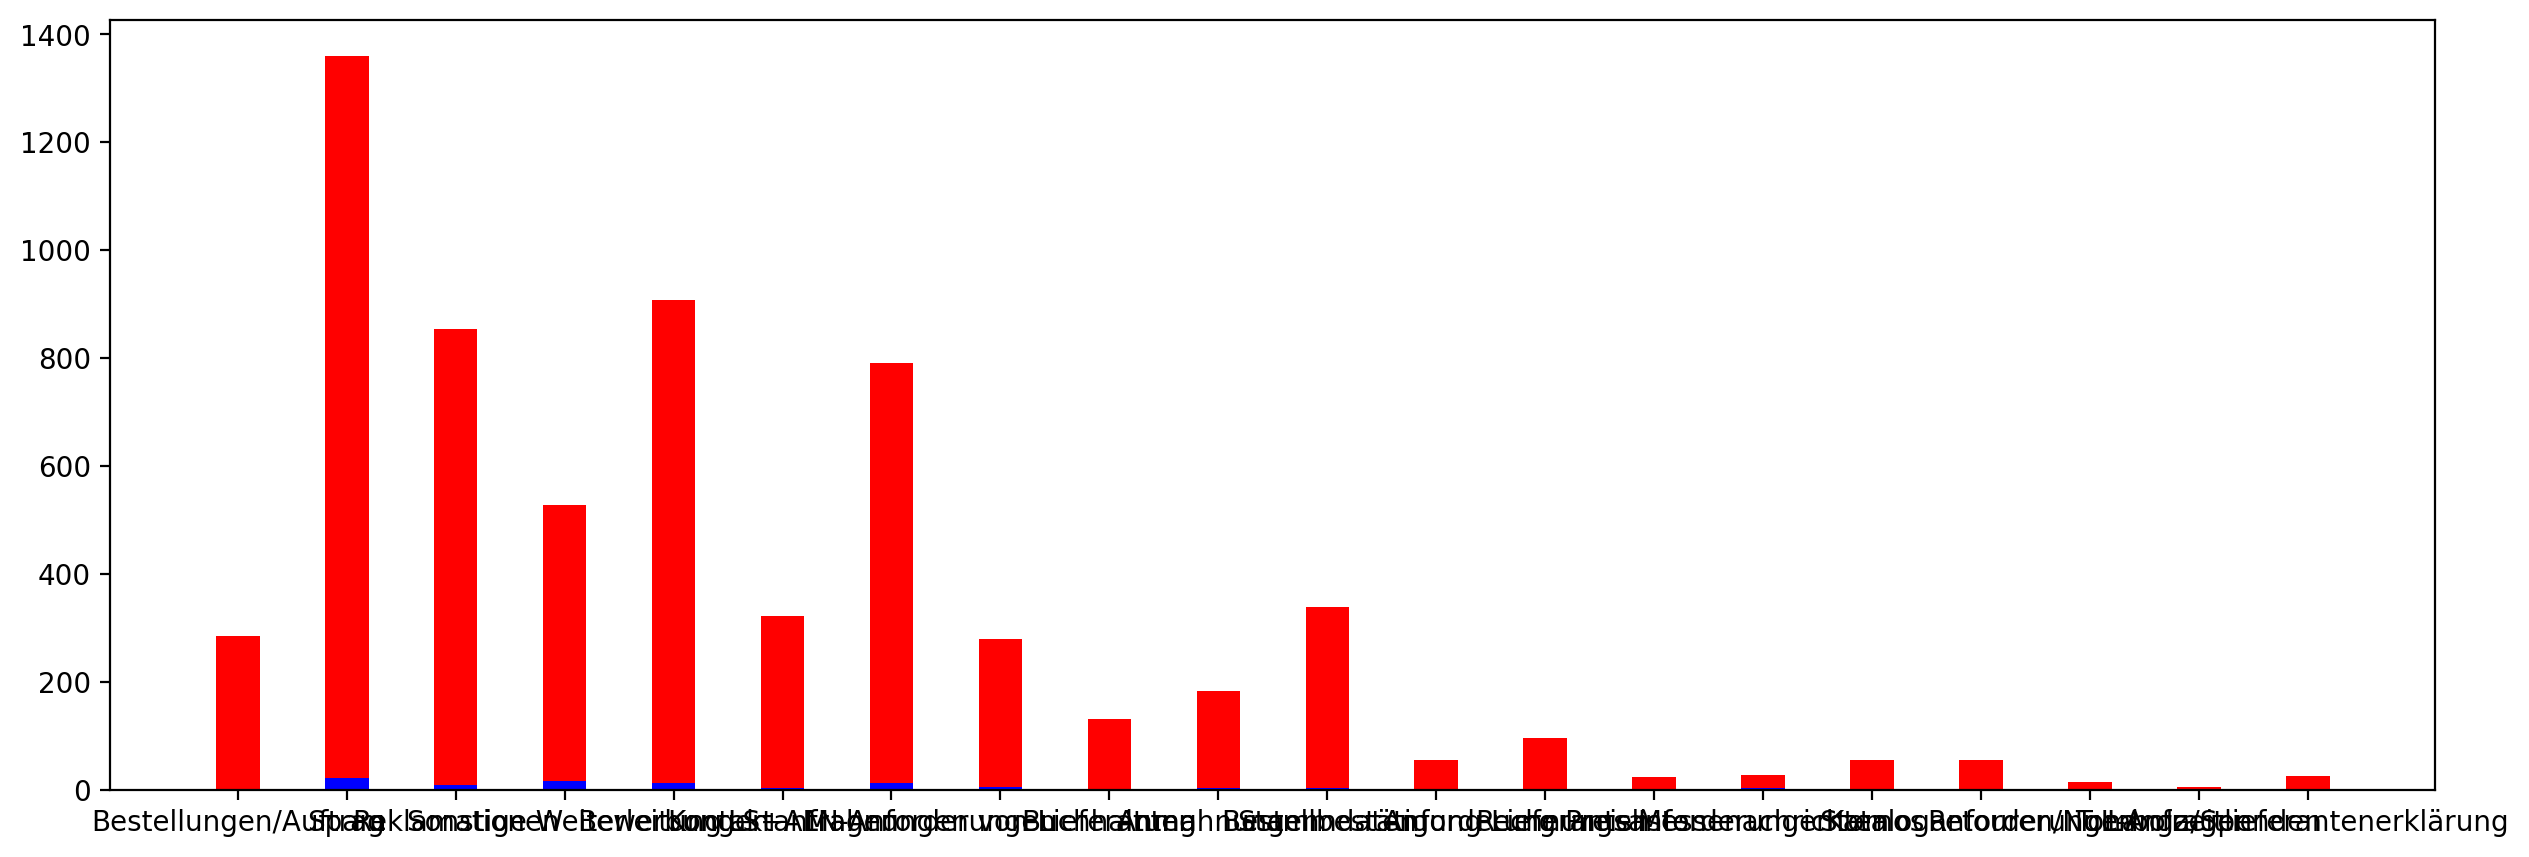

In [370]:
width = 0.4
Y_train_labeled = [index_to_cat[y] for y in Y_train]
Y_test_labeled = [index_to_cat[y] for y in Y_test]
counted_train = Counter(Y_train_labeled)
counted_test = Counter(Y_test_labeled)

fig, ax = plt.subplots(figsize=(15, 5))
train = ax.bar(counted_train.keys(), counted_train.values(),width, color='r')

test = ax.bar(counted_test.keys(), counted_test.values(),width, color='b')


In [371]:
pd.set_option("max_colwidth", 150)
pd.DataFrame({"Email": X_train, "Class": Y_train, 'Class_Name':Y_train_labeled})
df = pd.DataFrame({"Email": X_train, "Class": Y_train, 'Class_Name':Y_train_labeled})
df['Class'] = pd.to_numeric(df['Class'])



In [372]:
df

,Email,Class,Class_Name
0,fwd:[gah sc] fax image from:[07144823231] 18.06.2022 12:43 bau und hobby baumarkt gmbh 07144823231 #5804 ₽ 1/ 2 bau & hobby baum...,0,Bestellungen/Auftrag
1,"bachelor thesis about backshoring and innovation\r\n to whom it may concern, my name is emma schlawinski, and i am a double degree student of in...",1,Spam
2,fwd:[gah sc] fax image from:[] 01/02/2022 16:16 hagebaumarkt salzkotten (fax)05258 9744618 p.002/005 gah alberts ideen für haus und...,2,Reklamationen
3,"106073 - gah-alberts gmbh & co kg - taskcenter -\r\n uebersicht ihrer offenen tasks sehr geehrte damen und herren, in ihrem bahag.com task-cente...",3,Sonstige Weiterleitung
4,"fwd:[gah sc] fax image from:[+49(6348)604000]\n gust. alberts gmbh & co. kg blumenthal herscheid germany hra , ag iserlohn, pers. haft. ges.: al...",2,Reklamationen
...,...,...,...
6325,liefermahnung zur bestellung,10,Stammdaten
6326,liefermahnung zur bestellung,10,Stammdaten
6327,liefermahnung zur bestellung,10,Stammdaten
6328,liefermahnung zur bestellung,10,Stammdaten


Downsampling

In [373]:
from sklearn.utils import shuffle
def downsample(df, perc):
    df_new = pd.DataFrame()
    df = shuffle(df)
    for label_num in df.Class.unique():
        df1 = df[df.Class==label_num]
        df1 = df1.sample(round(len(df1)*perc))
        df_new = pd.concat([df_new,df1])
        df_new = shuffle(df_new)        
    print(len(df_new.Class.unique()))
    return df_new
df=downsample(df,0.5)

21


In [374]:
df=df.reset_index()

In [375]:
#df.drop('index')
df=df.drop(columns=['index'])

In [376]:
df

,Email,Class,Class_Name
0,"neolog anfrage muster sehr geehrte damen und herren, gerne würden wir zum test ein muster von einem ihrer artikel anfordern. art.-nr. x kantensc...",6,LS+ALN-Anforderungen
1,"absperrpfosten klappy sehr geehrte damen und herren, ich muss meinen personengebundenen behindertenparkplatz gegen unberechtigte fremdnutzung sc...",6,LS+ALN-Anforderungen
2,"- 14 kg in 1 monat ohne fasten, ohne bewegung\r\n - kg in monat ohne fasten, ohne bewegung rmafnnvf xqtrkhvvep cymi g b q",1,Spam
3,fwd:[gah sc] fax image from:[] verlag dashoefer 040-41332110 unser seminar-angebot für sie! verlag dashöfer gmbh business-seminare g...,1,Spam
4,"send me your product details/e-catalog. dear sir madam, my name is kofi vincent, i am a government licensed broker in ghana involved in import e...",6,LS+ALN-Anforderungen
...,...,...,...
3163,"kundenkonto sehr geehrte damen und herren, bitte senden sie uns einen händlerzugang. vielen dank ihr michael schraeder geschäftsführer telefon +...",6,LS+ALN-Anforderungen
3164,"preis pfosten hallo, wir bräuchten bitte ek preis uvp und versandkosten für eine einzelbestellung von kombipfosten mm mm kombipfosten mm mm viel...",4,Bewerbungen
3165,"commercial request dear sir or mme, i am the area manager of pum sas and i could see on your website that you sell stainless steel round bars. t...",6,LS+ALN-Anforderungen
3166,"anfrage kesseböhmer projekt: 240012769 sehr geehrte damen und herren, auf der grundlage der allgemeinen einkaufsbedingungen der kesseböhmer unte...",4,Bewerbungen


Remove Stop Words

In [377]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings


data = df
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# remove html-tags
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

# remove punctuation 
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

##we want non-alphabetic characters!

#def keepAlpha(sentence):
#    alpha_sent = ""
#    for word in sentence.split():
#        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
#        alpha_sent += alpha_word
#        alpha_sent += " "
#    alpha_sent = alpha_sent.strip()
#    return alpha_sent

df['Email'] = df['Email'].str.lower()
df['Email']= df['Email'].apply(cleanHtml)
df['Email']= df['Email'].apply(cleanPunc)
#df['Email']= df['Email'].apply(keepAlpha)
stop_words = set(stopwords.words('german'))
#len(stop_words)

In [378]:
stop_words.update(stopwords.words('english'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

In [379]:
df['Email']= df['Email'].apply(removeStopWords)
#len(stop_words)

In [380]:
df

,Email,Class,Class_Name
0,neolog anfrage muster geehrte damen herren gerne test muster artikel anfordern art -nr x kantenschutzprofil x cm wäre möglich viele...,6,LS+ALN-Anforderungen
1,absperrpfosten klappy geehrte damen herren personengebundenen behindertenparkplatz unberechtigte fremdnutzung schützen dafür möchte ggf ...,6,LS+ALN-Anforderungen
2,- 14 kg 1 monat fasten bewegung\r - kg monat fasten bewegung rmafnnvf xqtrkhvvep cymi g b q,1,Spam
3,fwd:[gah sc] fax image [] verlag dashoefer 040-41332110 seminar-angebot verlag dashöfer gmbh business-seminare gustav alberts g...,1,Spam
4,send product details e-catalog dear sir madam name kofi vincent government licensed broker ghana involved import export business sinc...,6,LS+ALN-Anforderungen
...,...,...,...
3163,kundenkonto geehrte damen herren bitte senden händlerzugang vielen dank michael schraeder geschäftsführer telefon + - schraeder schraeder...,6,LS+ALN-Anforderungen
3164,preis pfosten hallo bräuchten bitte ek preis uvp versandkosten einzelbestellung kombipfosten mm mm kombipfosten mm mm vielen dank sebastian...,4,Bewerbungen
3165,commercial request dear sir mme area manager pum sas could see website sell stainless steel round bars tell little know c...,6,LS+ALN-Anforderungen
3166,anfrage kesseböhmer projekt: 240012769 geehrte damen herren grundlage allgemeinen einkaufsbedingungen kesseböhmer unternehmensgruppe stan...,4,Bewerbungen


In [381]:
LABEL_COLUMNS = df['Class']

BERT Model

Train Test Split

In [382]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.05,shuffle=True)

train_df = train_df.reset_index()
val_df = val_df.reset_index()

train_df = train_df.drop(columns=['index'])
val_df= val_df.drop(columns=['index'])

In [383]:
train_df.shape,val_df.shape

((3009, 3), (159, 3))

In [384]:
train_df.head(2)

,Email,Class,Class_Name
0,fwd:[gah sc] fax image [+49 6348 604000]\r 04 11 2021 23:45:26 hornbach baumarkt ag 1 2 hornbach bouwmarkt nederland b v hornbach...,9,Anmahnungen
1,gah de 密码过期通知­ 电子邮件 存储 升级 您的电子邮件存储空间已达到极限 *电邮储存: % 充分 需要采取的行动: 您必须立即将电子邮件存储空间升级到 gb 此电子邮件服务快速，简便且免费 如果您在 小时内未执行此操作，则您的电子邮件帐户将被关闭，所有数据将永久丢失 升级...,1,Spam


Tokenization

In [385]:
from transformers import BertTokenizer, BertModel
from transformers import pipeline
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

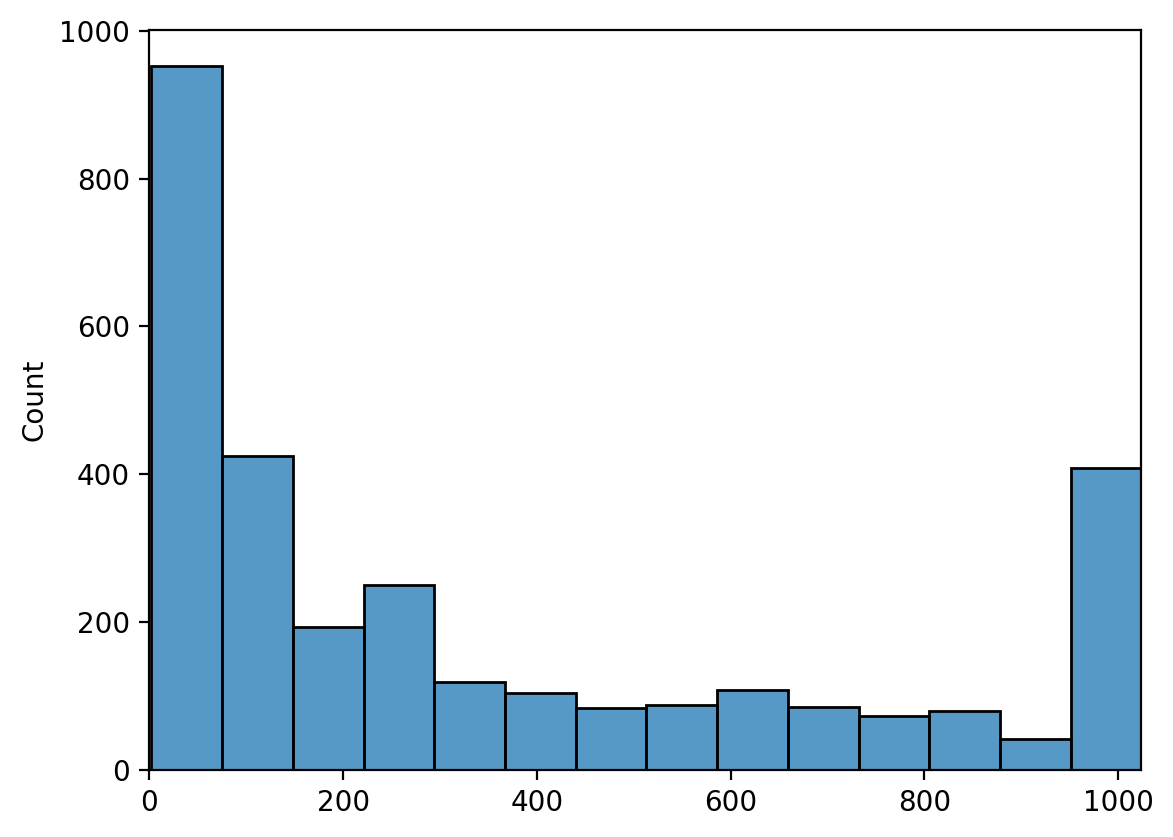

In [386]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["Email"],
    max_length=1024,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 1024]);

In [387]:
MAX_TOKEN_COUNT = 256

In [388]:
class ToxicCommentsDataset(Dataset):
    def __init__(
        self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 256
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = data_row.Email  # I changed here to 'Email'
        # labels = data_row[LABEL_COLUMNS]# this remains the same
        labels = data_row.Class
        #print(labels)
        # labels_tensor=torch.tensor(labels)
        # labels=torch.FloatTensor(labels)
        # print('the label is',labels,'with size',labels.size())
        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return dict(
            comment_text=comment_text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=np.array(labels),
            # labels=F.one_hot(labels_tensor,num_classes=21)#, num_classes=21)
        )

In [389]:
#ds = ToxicCommentsDataset(train_df, tokenizer, 512)
#ds[4].keys()

In [390]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) #, return_dict=True) # max_position_embeddings=1024)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [391]:
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=1, max_token_len=256):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = ToxicCommentsDataset(
            self.train_df, self.tokenizer, self.max_token_len
        )
        self.test_dataset = ToxicCommentsDataset(
            self.test_df, self.tokenizer, self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0,  # is this a problem?
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0,  # is this a problem?
        )

In [392]:
N_EPOCHS = 8
BATCH_SIZE = 1


In [393]:
data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT)

In [1]:
from torchmetrics.functional import accuracy
class ToxicCommentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.func = nn.Softmax(dim=1)
        #print("hello1")
        # self.criterion = nn.BCELoss()
        # self.criterion =nn.NLLLoss
        # sparcecategoricalcross
        # self.criterion = BCEWithLogitsLoss()
        self.criterion = nn.CrossEntropyLoss()
        self.save_hyperparameters() ##added here
        self.train_acc=torchmetrics.Accuracy()
        self.valid_acc=torchmetrics.Accuracy()
        self.test_acc=torchmetrics.Accuracy()
        wandb.watch(self.bert,self.criterion,log='all')

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        #print("hello2")
        #print('output.pooler_output',output.pooler_output.shape)
        output = self.classifier(output.pooler_output)
        #print("hello3")
        #print("output shape after linear layer", output.shape)  # (4,6630)
        # output = torch.sigmoid(output)
        # output = nn.ReLU(output)
        # output = torch.sigmoid(output)
        output = self.func(output)
        # output=torch.exp(output)
        #print("the output of activation function is", output)  # (4,6330)
        #print(
            #"output size of activation function is", output.size()
        #)  # torch.Size([1, 21])
        loss = 0
        # print('labels and label shape are',labels,labels.shape)
        #print("hello3")
        #print("shape of labels is ", labels.size())  # (4,21)
        #print("labels are:", labels)
        
        if labels is not None:
            #print("output type", type(output))
            #print("labels type", labels)
            loss = self.criterion(output, labels) # the problem is here?
        return loss, output
    
    
        #print("hello5")
        # print(batch.size())
        ### it stops here

    def training_step(self, batch, batch_idx):
        #print("hello6")
        input_ids = batch["input_ids"]
        #print(input_ids.shape)
        attention_mask = batch["attention_mask"]
        #print(attention_mask.shape)
        labels = batch["labels"]
        #print(labels.shape)
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True,on_epoch=True)
        wandb.log({"train_loss": loss, "epochs": N_EPOCHS}) ##added here
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        #wandb.log({"test_loss": loss, "epochs": N_EPOCHS}) #added this
        return loss

    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        #model_filename='model_final_bert.onnx' ## I added this
        #torch.onnx.export(self,predictions,model_filename)
        #wandb.save(model_filename)
        
        
#         for i, name in enumerate(LABEL_COLUMNS):
#             class_roc_auc = auroc(predictions[:, i], labels[:, i])
#             self.logger.experiment.add_scalar(
#                 f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch
#             )

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps,
        )
        return dict(
            optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval="step")
        )
#LitMLP.training_step=training_step()
#LitMLP.configure_optimizers=configure_optimizers()
#LitMLP.test_step=test_step()
#LitMLP.test_epoch_end=test_epoch_end()

NameError: name 'pl' is not defined

Optimizer

In [395]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(4814, 24072)

In [396]:
model = ToxicCommentTagger(
  #n_classes=21,
  n_classes=21, 
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training

In [397]:
checkpoint_filepath = '/tmp/checkpoint'

checkpoint_callback = ModelCheckpoint(
  #filepath=checkpoint_filepath,
  dirpath="checkpoint_filepath",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [398]:
#logger = TensorBoardLogger("lightning_logs", name="bert_model")

In [399]:
from pytorch_lightning.loggers import WandbLogger

In [400]:
logger=WandbLogger(project='bert_text_classification_s')

In [401]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)

In [402]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

trainer = pl.Trainer(
  logger=logger,
  #checkpoint_callback=checkpoint_callback,
  #callbacks=[early_stopping_callback],
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=8,
  accelerator = 'cpu',
  #progress_bar_refresh_rate=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [403]:
trainer.fit(model, data_module)


  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 108 M 
1 | classifier | Linear           | 16.1 K
2 | func       | Softmax          | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | train_acc  | Accuracy         | 0     
5 | valid_acc  | Accuracy         | 0     
6 | test_acc   | Accuracy         | 0     
------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.306   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3009: 'val_loss' reached 2.68344 (best 2.68344), saving model to '/Users/saranobrega/Desktop/test_pl/outsmart-text-classifier/checkpoint_filepath/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 6018: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 9027: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 12036: 'val_loss' reached 2.65029 (best 2.65029), saving model to '/Users/saranobrega/Desktop/test_pl/outsmart-text-classifier/checkpoint_filepath/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 15045: 'val_loss' reached 2.60575 (best 2.60575), saving model to '/Users/saranobrega/Desktop/test_pl/outsmart-text-classifier/checkpoint_filepath/best-checkpoint-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 18054: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 21063: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 24072: 'val_loss' reached 2.60018 (best 2.60018), saving model to '/Users/saranobrega/Desktop/test_pl/outsmart-text-classifier/checkpoint_filepath/best-checkpoint-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=8` reached.


Evaluation

In [404]:
trainer.test(datamodule=data_module)

Restoring states from the checkpoint path at /Users/saranobrega/Desktop/test_pl/outsmart-text-classifier/checkpoint_filepath/best-checkpoint-v2.ckpt
Loaded model weights from checkpoint at /Users/saranobrega/Desktop/test_pl/outsmart-text-classifier/checkpoint_filepath/best-checkpoint-v2.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.60017991065979
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.60017991065979}]

In [405]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
test_loss,▁
train_loss_epoch,█▄▅▃▂▂▂▁
train_loss_step,████▁██▁█▁▁████▁█▆▃█▁█▁██▁█▁▁█▁█▁▁█▇▁▁█▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▅█▇▃▁▄▂▁
epoch,7
test_loss,2.60018
train_loss_epoch,2.65653
train_loss_step,3.10458
trainer/global_step,24072
